In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from eecs598.utils import reset_seed
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import CosineAnnealingLR


# for plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline

from ph1 import *
from helper import *
from load_cifar10 import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.4.1
cuda


In [3]:
to_float= torch.float
to_long = torch.long
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
data_dir='./datasets'
loader_train, loader_val, loader_test = load_CIFAR10(data_dir, batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


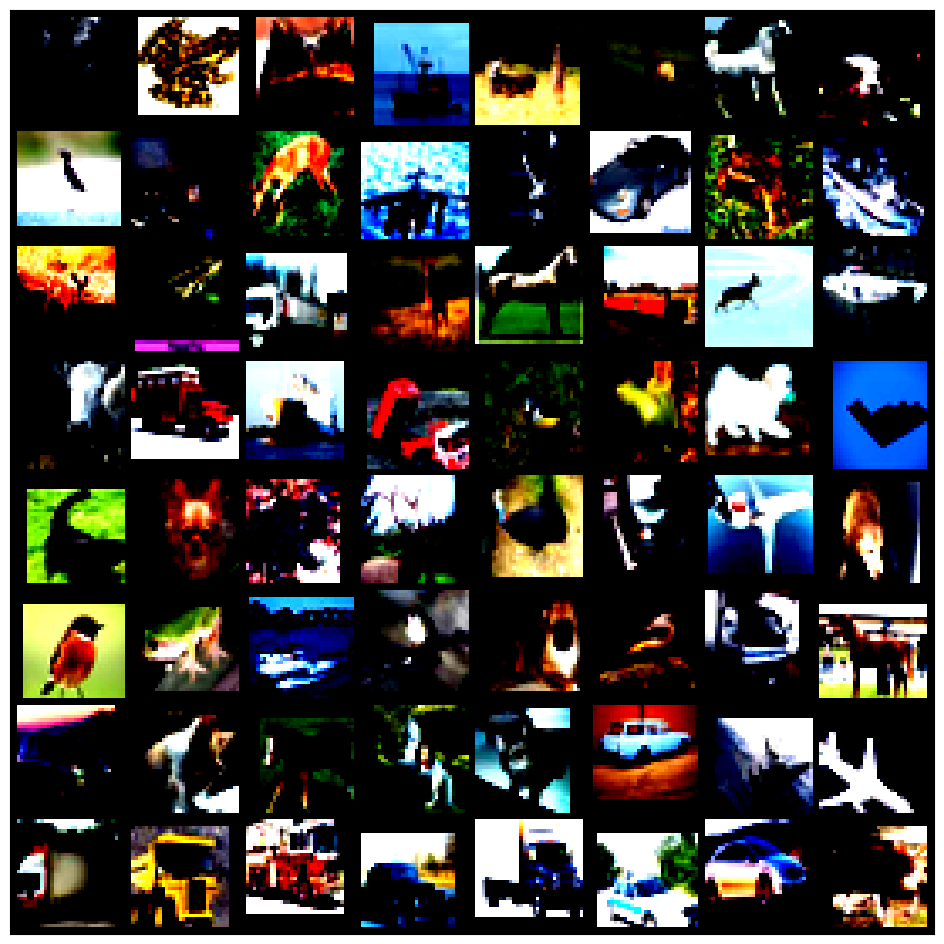

In [5]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(loader_train)

In [6]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
    """
    Adjusts the learning rate by multiplying it with lrd at specified epochs.
    
    Inputs:
    - optimizer: PyTorch optimizer object.
    - lrd: Learning rate decay factor.
    - epoch: Current epoch number.
    - schedule: List of epochs to decay the learning rate.

    Returns: None (updates optimizer's learning rate in place).
    """
    if epoch in schedule:
        for param_group in optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = old_lr * lrd
            param_group['lr'] = new_lr
            print(f'Learning rate updated from {old_lr:.6f} to {new_lr:.6f}')


def check_accuracy(loader, model, device='cpu', dtype=torch.float32):
    """
    Check model accuracy on the given dataset loader.

    Inputs:
    - loader: DataLoader containing the dataset to evaluate on.
    - model: PyTorch model to evaluate.
    - device: Device to perform computations on ('cpu' or 'cuda').
    - dtype: Data type for input tensors.

    Returns:
    - acc: Computed accuracy as a float.
    """
    try:
        model.eval()  # Set the model to evaluation mode
    except:
        pass
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum().item()
            num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print(f'Validation accuracy: {num_correct} / {num_samples} ({100.0 * acc:.2f}%)')
    return acc


def train_model(model, optimizer, loader_train, loader_val, 
                device='cpu', dtype=torch.float32, epochs=1, scheduler=None,
                learning_rate_decay=0.1, schedule=[], verbose=True,model_path='./models/best.pth'):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: PyTorch model to train.
    - optimizer: PyTorch optimizer for training.
    - loader_train: DataLoader for the training set.
    - loader_val: DataLoader for the validation set.
    - device: Device to perform computations on ('cpu' or 'cuda').
    - dtype: Data type for input tensors.
    - epochs: Number of epochs to train for.
    - learning_rate_decay: Factor to decay the learning rate.
    - schedule: List of epochs to apply learning rate decay.
    - verbose: Whether to print progress and accuracy.

    Returns:
    - acc_history: List of validation accuracies during training.
    """
    model = model.to(device)
    acc_history = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        print(f"Starting epoch {epoch + 1}/{epochs}...")

        for t, (x, y) in enumerate(loader_train):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device)

            # Forward pass
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if verbose and t % 100 == 0:
                print(f"Iteration {t}, loss = {loss.item():.4f}")

        # Adjust learning rate if the current epoch is in the schedule
        if scheduler != None:
            scheduler.step()
        else:
            adjust_learning_rate(optimizer, learning_rate_decay, epoch, schedule)
            
        # Check accuracy after each epoch
        acc = check_accuracy(loader_val, model, device=device, dtype=dtype)
        acc_history.append(acc)

        torch.save(model.state_dict(), model_path)

    return acc_history


In [7]:
# example of specifications
networks = {
    'resnet18': {
      'block': ResidualBlock,
      'stage_args': [
          (64, 64, 5, False),
          (64, 128, 5, True),
          (128, 256, 5, True),
          (256, 512, 5, True),
      ]
    }
}

def get_resnet(name):
  # YOUR_TURN: Impelement ResNet.__init__ and ResNet.forward
  return ResNet(**networks[name])

In [8]:

name = 'resnet18'
version = 1
model_path = f'./models/{name}_{version}.pth'
if os.path.exists(model_path):
  model = get_resnet(name).to(device) 
  state_dict = torch.load(model_path, weights_only=True)
  model.load_state_dict(state_dict)
  check_accuracy(loader_test, model, device='cuda')
else:
  acc_history_dict = {}
  iter_history_dict = {}
  reset_seed(0)
  print(name, '\n')
  model = get_resnet(name).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=.9, weight_decay=5e-4)
  scheduler = CosineAnnealingLR(optimizer, T_max=40)

  acc_history = train_model(model, optimizer, loader_train, loader_val,device='cuda',
                             epochs=40, schedule=[6, 15], scheduler=scheduler,
                              verbose=False, model_path=model_path)
  acc_history_dict[name] = acc_history
  torch.save(model.state_dict(), model_path)

resnet18 

Starting epoch 1/40...
Validation accuracy: 2505 / 5000 (50.10%)
Starting epoch 2/40...
Validation accuracy: 3061 / 5000 (61.22%)
Starting epoch 3/40...
Validation accuracy: 3389 / 5000 (67.78%)
Starting epoch 4/40...
Validation accuracy: 3641 / 5000 (72.82%)
Starting epoch 5/40...
Validation accuracy: 3825 / 5000 (76.50%)
Starting epoch 6/40...
Validation accuracy: 3859 / 5000 (77.18%)
Starting epoch 7/40...
Validation accuracy: 4096 / 5000 (81.92%)
Starting epoch 8/40...
Validation accuracy: 3775 / 5000 (75.50%)
Starting epoch 9/40...
Validation accuracy: 3776 / 5000 (75.52%)
Starting epoch 10/40...
Validation accuracy: 4096 / 5000 (81.92%)
Starting epoch 11/40...
Validation accuracy: 4227 / 5000 (84.54%)
Starting epoch 12/40...
Validation accuracy: 4137 / 5000 (82.74%)
Starting epoch 13/40...
Validation accuracy: 4143 / 5000 (82.86%)
Starting epoch 14/40...
Validation accuracy: 4275 / 5000 (85.50%)
Starting epoch 15/40...
Validation accuracy: 4329 / 5000 (86.58%)
Starting